In [1]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import autogluon.core as ag
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error
import torch

c:\Users\Alex\miniconda3\envs\env2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.cuda.is_available())  # Should be True
print(torch.cuda.device_count())  # Should be > 0

True
1


In [3]:
df_avg = pd.read_pickle('../Data/ELC_12-14_1D_dropped_avg.pkl')

df_avg_convert = df_avg.copy()
df_avg_convert['id'] = 1
df_avg_convert = df_avg_convert.rename(columns = {"y": "target"})
df_avg_convert = TimeSeriesDataFrame.from_data_frame(
    df_avg_convert,
    id_column="id",
    timestamp_column="ds"
)

df_avg_convert.head()

target
item_id timestamp               
1       2012-01-01  38313.751557
        2012-01-02  57225.098775
        2012-01-03  57294.353754
        2012-01-04  57503.687632
        2012-01-05  57662.515150

In [49]:
df_avg.iloc[int(len(df_avg)*0.9):].index

DatetimeIndex(['2014-09-13', '2014-09-14', '2014-09-15', '2014-09-16',
               '2014-09-17', '2014-09-18', '2014-09-19', '2014-09-20',
               '2014-09-21', '2014-09-22',
               ...
               '2014-12-22', '2014-12-23', '2014-12-24', '2014-12-25',
               '2014-12-26', '2014-12-27', '2014-12-28', '2014-12-29',
               '2014-12-30', '2014-12-31'],
              dtype='datetime64[ns]', length=110, freq='D')

In [4]:
training_x = df_avg_convert.iloc[:int(len(df_avg_convert)*0.9)]
val_x = df_avg_convert.iloc[int(len(df_avg_convert)*0.8):int(len(df_avg_convert)*0.9)]
testing_x = df_avg_convert.iloc[int(len(df_avg_convert)*0.9):]
print("training: ", training_x.shape)
print("validation: ", val_x.shape)
print("testing: ", testing_x.shape)

training:  (986, 1)
validation:  (110, 1)
testing:  (110, 1)


In [6]:
predictor_DAR = TimeSeriesPredictor(prediction_length = 110, eval_metric="MAPE", presets="high_quality")

predictor_DAR.fit(
    training_x,
    hyperparameters={
        "DeepAR":{
            # "hidden_size": ag.space.Int(20, 100),
            # "dropout_rate": ag.space.Categorical(0.1, 0.3)
            }
    },
    ag_args_fit={'num_gpus': 1},
)

No path specified. Models will be saved in: "AutogluonModels\ag-20230502_215537\"
================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Fitting with arguments:
{'ag_args_fit': {'num_gpus': 1},
 'enable_ensemble': True,
 'evaluation_metric': 'MAPE',
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': {'DeepAR': {}},
 'prediction_length': 110,
 'random_seed': None,
 'target': 'target',
 'time_limit': None}
Provided training data set with 986 rows, 1 items (item = single time series). Average time series length is 986.0.
Training artifacts will be saved to: C:\Users\Alex\OneDrive - University of Rochester\Desktop\2023Spring\Forcasting\IEOR4574-Forcasting\Electricity_Forecasting\Model\AutogluonModels\ag-20230502_215537
AutoGluon will save models to AutogluonModels\ag-20230502_215537\
AutoGluon will gauge predictive performance using evaluation metric: 'MAPE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score 

In [23]:
predictions_DAR = predictor_DAR.predict(training_x)
best_mape = mean_absolute_percentage_error(testing_x['target'], predictions_DAR['mean'])
print(best_mape)

Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: DeepAR


0.2441849643481262


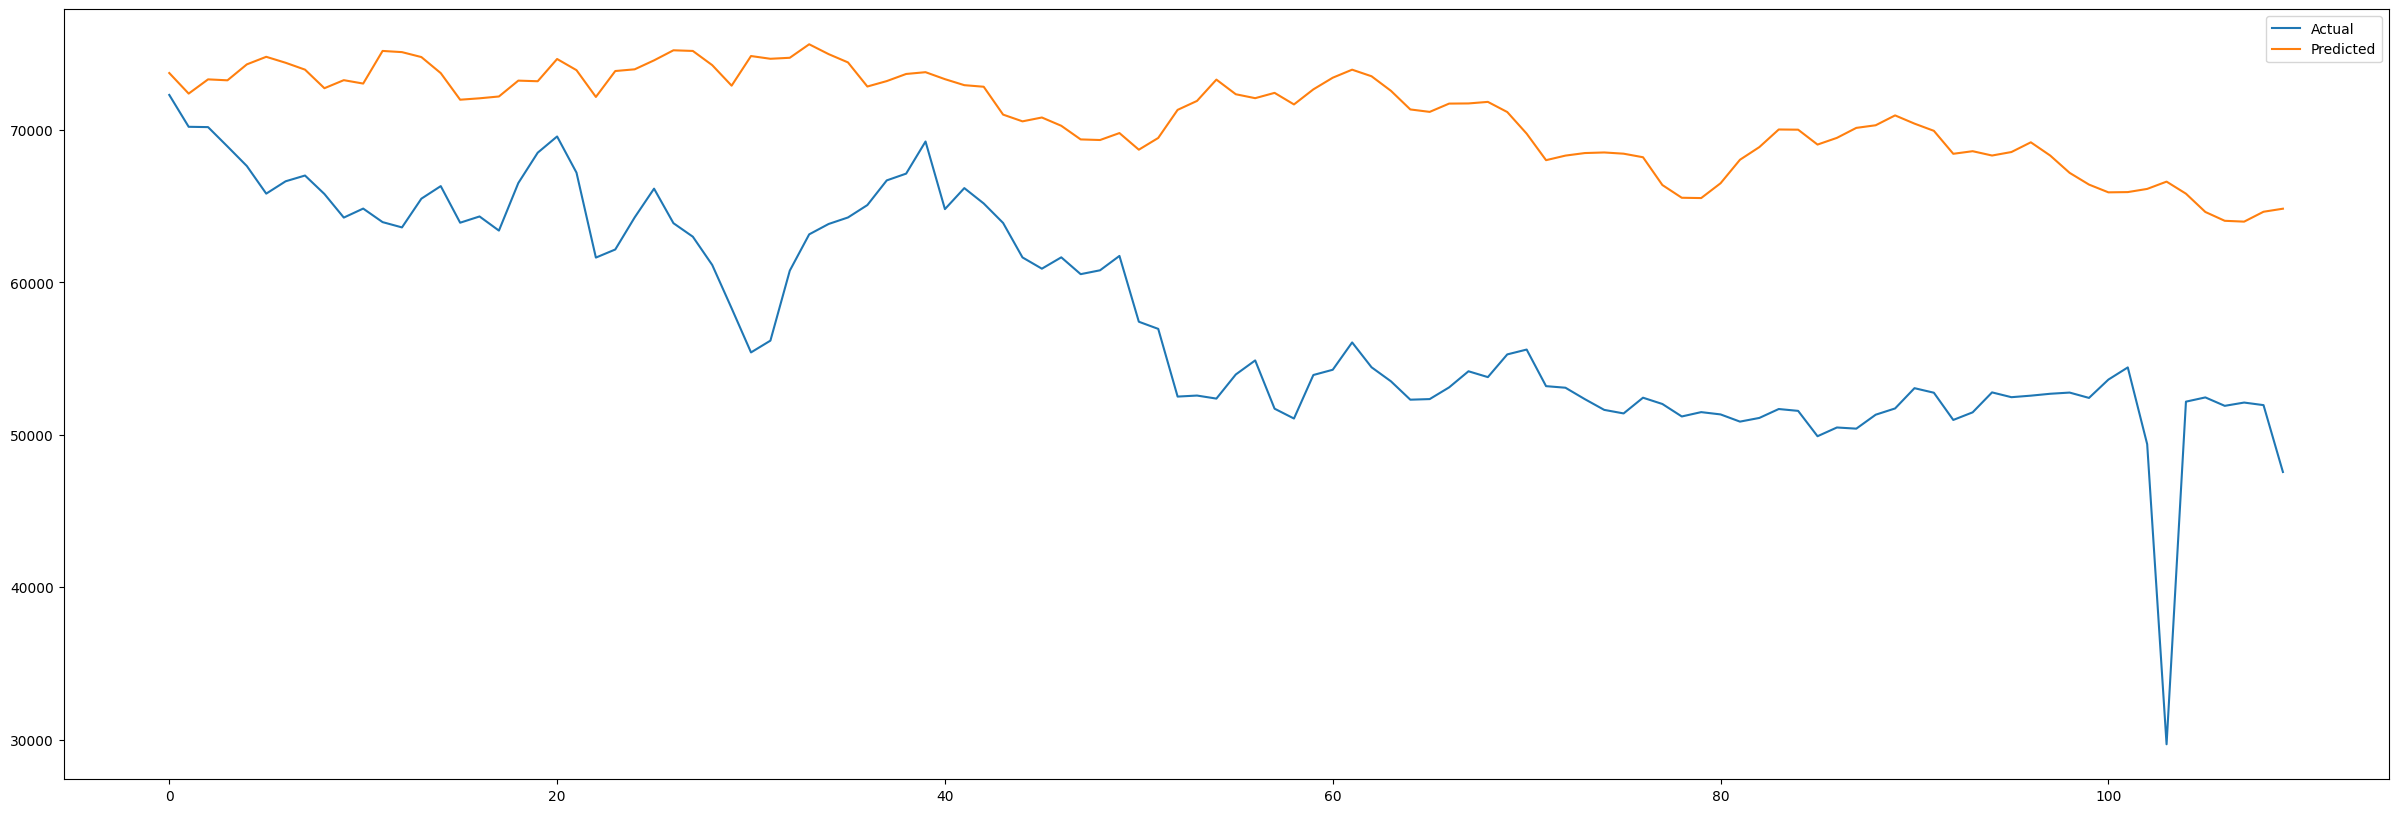

In [71]:
plt.figure(figsize=(30,10))
plt.plot(testing_x['target'].values, label='Actual')
plt.plot(predictions_DAR['mean'].values,label='Predicted')
plt.legend()
plt.show()

MAPE test1:  0.1454807602521145
MAPE test2:  0.25068732482082756
MAPE test3:  0.33371912677965243


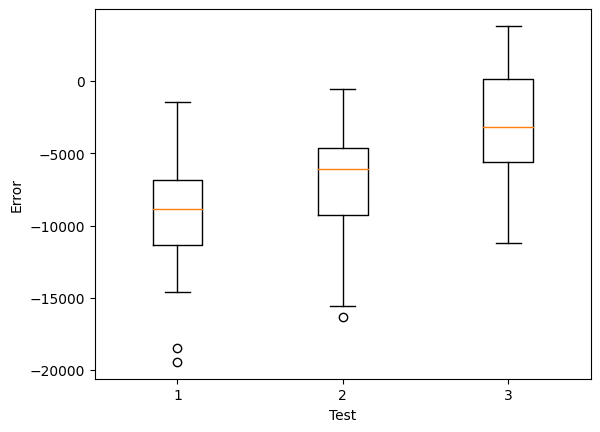

In [70]:
test1 = testing_x.iloc[:int(len(testing_x)/3)].reset_index(drop=True)
test2 = testing_x.iloc[int(len(testing_x)/3):int(len(testing_x)*2/3)].reset_index(drop=True)
test3 = testing_x.iloc[int(len(testing_x)*2/3):].reset_index(drop=True)

predictions_DAR_1 = predictions_DAR.iloc[:int(len(predictions_DAR)/3)].reset_index(drop=True)
predictions_DAR_2 = predictions_DAR.iloc[int(len(predictions_DAR)/3):int(len(predictions_DAR)*2/3)].reset_index(drop=True)
predictions_DAR_3 = predictions_DAR.iloc[int(len(predictions_DAR)*2/3):].reset_index(drop=True)

err = pd.DataFrame(columns=['test1','test2','test3'])
mape_test = []

err['test1'] = test1['target'] - predictions_DAR_1['mean']
mape_test.append(mean_absolute_percentage_error(test1['target'], predictions_DAR_1['mean']))
print("MAPE test1: ", mean_absolute_percentage_error(test1['target'], predictions_DAR_1['mean']))

err['test2'] = test1['target'] - predictions_DAR_2['mean']
mape_test.append(mean_absolute_percentage_error(test2['target'], predictions_DAR_2['mean']))
print("MAPE test2: ", mean_absolute_percentage_error(test2['target'], predictions_DAR_2['mean']))

err['test3'] = test1['target'] - predictions_DAR_3['mean']
mape_test.append(mean_absolute_percentage_error(test3['target'], predictions_DAR_3['mean']))
print("MAPE test3: ", mean_absolute_percentage_error(test3['target'], predictions_DAR_3['mean']))

plt.boxplot(err)
plt.xlabel('Test')
plt.ylabel('Error')
plt.show()
